In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ff_data = pd.read_csv("ff_data.csv")

In [3]:
ff_data.head()

Player      Team FantPos  Age   G   Cmp  PassAtt  PassYds  PassTD  \
0  DeMarcoMurray   Cowboys      RB   26  16  0.00     0.00     0.00    0.00   
1  MarshawnLynch  Seahawks      RB   28  16  0.00     0.00     0.00    0.00   
2   AntonioBrown  Steelers      WR   26  16  0.12     0.12     1.25    0.06   
3      MattForte     Bears      RB   29  16  0.00     0.00     0.00    0.00   
4      EddieLacy   Packers      RB   24  16  0.00     0.00     0.00    0.00   

   Int  ...  PosRank  OvRank  Year   adp  draft_pick  draft_year  Experience  \
0  0.0  ...        1     1.0  2014  14.2          71        2011           3   
1  0.0  ...        3     3.0  2014  15.9          12        2007           7   
2  0.0  ...        1     4.0  2014  18.4         195        2010           4   
3  0.0  ...        4     5.0  2014   4.2          44        2008           6   
4  0.0  ...        6     7.0  2014   6.2          61        2013           1   

   Rookie  Soph  Third  
0       0     0      0  
1       0     0      0  
2       0     0      0  
3       0     0      0  
4       0     1      0  

[5 rows x 28 columns]

In [4]:
rookies = ff_data[ff_data["Rookie"]==1]
sophs = ff_data[ff_data["Soph"]==1]
thirds = ff_data[ff_data["Third"]==1]

In [5]:
from scipy.stats import ttest_ind

In [6]:
print(ttest_ind(rookies["PPR"], sophs["PPR"]).pvalue)
print(ttest_ind(rookies["PPR"], thirds["PPR"]).pvalue)
print(ttest_ind(sophs["PPR"], thirds["PPR"]).pvalue)

0.000892051328545278
3.6832257688679865e-06
0.19143539006646135


By using t-test to compare the sample means for rookies vs. sophomore and third year players, we can see that there is significance for us to fail to reject the alternative hypothesis regarding rookie performance vs. other years. However, there is not sufficient evidence for us to claim that there is a significant difference between sophomore and third year performance.

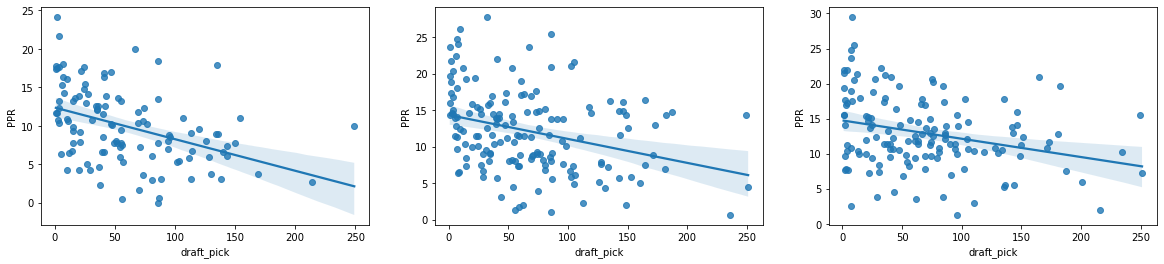

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
sns.regplot(x="draft_pick", y="PPR", data=rookies, ax=axs[0])
sns.regplot(x="draft_pick", y="PPR", data=sophs, ax=axs[1])
sns.regplot(x="draft_pick", y="PPR", data=thirds, ax=axs[2]);

In [8]:
import statsmodels.api as sm

orlm_X = rookies["draft_pick"]
orlm_X = sm.add_constant(orlm_X)

orlm = sm.OLS(rookies["PPR"], orlm_X)
orlm_results = orlm.fit()
print(orlm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     23.55
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           3.97e-06
Time:                        11:32:19   Log-Likelihood:                -331.63
No. Observations:                 114   AIC:                             667.3
Df Residuals:                     112   BIC:                             672.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3839      0.653     18.964      0.0

In [9]:
oslm_X = sophs["draft_pick"]
oslm_X = sm.add_constant(oslm_X)

oslm = sm.OLS(sophs["PPR"], oslm_X)
oslm_results = oslm.fit()
print(oslm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     17.52
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           4.69e-05
Time:                        11:32:20   Log-Likelihood:                -496.64
No. Observations:                 161   AIC:                             997.3
Df Residuals:                     159   BIC:                             1003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3341      0.671     21.356      0.0

In [10]:
otlm_X = thirds["draft_pick"]
otlm_X = sm.add_constant(otlm_X)

otlm = sm.OLS(thirds["PPR"], otlm_X)
otlm_results = otlm.fit()
print(otlm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     12.75
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           0.000488
Time:                        11:32:21   Log-Likelihood:                -430.73
No. Observations:                 143   AIC:                             865.5
Df Residuals:                     141   BIC:                             871.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.7446      0.651     22.653      0.0

As we can see, the R^2 value is already fairly low for rookies, but as it is higher than the R^2 values for sophomores and third years, it is reasonable to assume that draft capital is a better predictor for fantasy performance for rookies relative to other years. We can directly apply this by claiming that draft capital should not matter as much for second year players when predicting performance. For the next part, we will more directly examine rookie performance, as draft capital serves as a better predictor.

First, we'll create an 80/20 split for train vs. test using rookie data.

In [11]:
from sklearn.model_selection import train_test_split

rookie_train, rookie_test = train_test_split(rookies, test_size=0.2)

As we see that the residual plot is skewed right, we want to make a better fit, so we take the log transformation and build a new model.

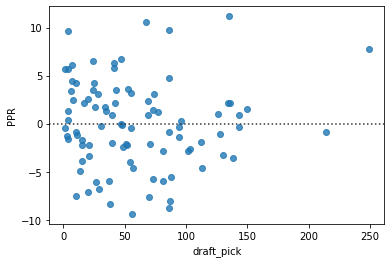

In [12]:
sns.residplot(x="draft_pick", y="PPR", data=rookie_train);

In [13]:
import statsmodels.api as sm

orlm_2_X = np.log(rookie_train["draft_pick"])
orlm_2_X = sm.add_constant(orlm_2_X)

orlm_2 = sm.OLS(rookie_train["PPR"], orlm_2_X)
orlm_2_results = orlm_2.fit()
print(orlm_2_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     22.80
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           7.04e-06
Time:                        11:32:25   Log-Likelihood:                -263.57
No. Observations:                  91   AIC:                             531.1
Df Residuals:                      89   BIC:                             536.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.6800      1.510     11.048      0.0

This improves the R^2 value, so we'll move forwards with it.

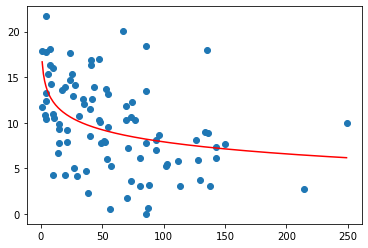

In [14]:
x=np.arange(1, 250)
y=(orlm_2_results.params[1] * (np.log(x))) + orlm_2_results.params[0]
plt.scatter(x=rookie_train["draft_pick"], y=rookie_train["PPR"])
plt.plot(x,y, color="red");

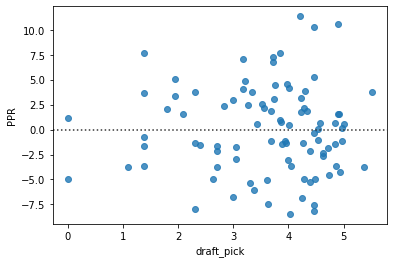

In [15]:
sns.residplot(x=np.log(rookie_train["draft_pick"]), y=rookie_train["PPR"]);

This clearly is a better fit. To further check fit, we need to do residual analysis for any outliers or cases with large influence on our final model. We will check studentized residuals as well as Cook's distance

In [16]:
orlm_2_resids = rookie_train["PPR"] - orlm_2_results.predict()
orlm_2_std_resids = (orlm_2_resids) / np.std(rookie_train["PPR"])
orlm_2_std_resids.sort_values()

138   -1.724010
161   -1.669465
127   -1.629182
868   -1.540756
720   -1.516144
         ...   
295    1.558426
316    1.570067
441    2.089728
320    2.158897
442    2.312521
Name: PPR, Length: 91, dtype: float64

This shows that there are no residual values greater than 3 or less than -3, proving there are no significant outliers.

In [17]:
from statsmodels.stats.outliers_influence import OLSInfluence

OLSInfluence(orlm_2_results).resid_studentized_internal.sort_values()

138   -1.922897
161   -1.866292
127   -1.828404
868   -1.722551
720   -1.689792
         ...   
316    1.750337
295    1.772876
441    2.336105
320    2.423217
442    2.581270
Length: 91, dtype: float64

This same sentiment is echoed with the studentized residuals, as no point has a studentized residual greater than 3 or less than -3.

In [18]:
OLSInfluence(orlm_2_results).cooks_distance[0].max()

0.09353418956727348

The maximum Cook's distance is far from the mark of .5 that indicates that a data point significantly changes the fit. Therefore, we can assume the current state of the data is free of threatening outliers. 

-------------

Since we are content with our current predictor, we want to better the model. This will involve adding a new feature, but to choose what feature to add, we need to use our domain knowledge. We do not have access to the players' college data nor combine data, but we can look at a few things relating to their position, the prior year production of the team they are drafted to.

First, we will use their position to create a categorical predictor. This is crucial, as any experience following the NFL tells us that it is very rare for a rookie QB to do well that is not drafted in the first round, but frequently late round receivers or running backs do well. To sort, we will dummy-encode, and leave no column for WRs/TEs so that we treat them as blanket pass catchers. There are so few tight ends it doesn't make sense to make them accounted for separate.

In [19]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

rookie_train["RB"] = ((rookie_train.FantPos=="RB")*1).copy()
rookie_train["QB"] = ((rookie_train.FantPos=="QB")*1).copy()

In [20]:
rookie_train

Player      Team FantPos  Age   G  Cmp  PassAtt  PassYds  \
136        JamesWhite  Patriots      RB   22   3  0.0      0.0      0.0   
152        ToddGurley      Rams      RB   21  13  0.0      0.0      0.0   
276     NelsonAgholor    Eagles      WR   22  13  0.0      0.0      0.0   
859    DarwinThompson    Chiefs      RB   22  12  0.0      0.0      0.0   
441        KareemHunt    Chiefs      RB   22  16  0.0      0.0      0.0   
..                ...       ...     ...  ...  ..  ...      ...      ...   
862  DarrellHenderson      Rams      RB   22  13  0.0      0.0      0.0   
82       TerranceWest    Browns      RB   23  14  0.0      0.0      0.0   
138       CodyLatimer   Broncos      WR   22   8  0.0      0.0      0.0   
880    JonathanTaylor     Colts      RB   21  15  0.0      0.0      0.0   
415      CoreyColeman    Browns      WR   22  10  0.0      0.0      0.0   

     PassTD  Int  ...  Year    adp  draft_pick  draft_year  Experience  \
136     0.0  0.0  ...  2014  154.9         130        2014           0   
152     0.0  0.0  ...  2015   60.2          10        2015           0   
276     0.0  0.0  ...  2015   56.6          20        2015           0   
859     0.0  0.0  ...  2019   86.0         214        2019           0   
441     0.0  0.0  ...  2017   18.7          86        2017           0   
..      ...  ...  ...   ...    ...         ...         ...         ...   
862     0.0  0.0  ...  2019   93.0          70        2019           0   
82      0.0  0.0  ...  2014  110.0          94        2014           0   
138     0.0  0.0  ...  2014  151.8          56        2014           0   
880     0.0  0.0  ...  2020   32.6          41        2020           0   
415     0.0  0.0  ...  2016  112.2          15        2016           0   

     Rookie  Soph  Third  RB  QB  
136       1     0      0   1   0  
152       1     0      0   1   0  
276       1     0      0   0   0  
859       1     0      0   1   0  
441       1     0      0   1   0  
..      ...   ...    ...  ..  ..  
862       1     0      0   1   0  
82        1     0      0   1   0  
138       1     0      0   0   0  
880       1     0      0   1   0  
415       1     0      0   0   0  

[91 rows x 30 columns]

In [21]:
orlm_3_X = pd.DataFrame({"pick": np.log(rookie_train["draft_pick"]), 
                         "RB": rookie_train["RB"], "QB": rookie_train["QB"], 
                         "RB_interact": rookie_train["RB"]*(np.log(rookie_train["draft_pick"])), 
                         "QB_interact": rookie_train["QB"]*(np.log(rookie_train["draft_pick"]))})
orlm_3_X = sm.add_constant(orlm_3_X)

orlm_3 = sm.OLS(rookie_train["PPR"], orlm_3_X)
orlm_3_results = orlm_3.fit()
print(orlm_3_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     7.636
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           5.76e-06
Time:                        11:32:34   Log-Likelihood:                -257.06
No. Observations:                  91   AIC:                             526.1
Df Residuals:                      85   BIC:                             541.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          15.4692      2.648      5.842      

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for idx in np.arange(len(orlm_3_X.columns.tolist())):
    print(f"VIF of {orlm_3_X.columns.tolist()[idx]}: {variance_inflation_factor(orlm_3_X, idx)}")

VIF of const: 35.811926824220365
VIF of pick: 4.282626938801509
VIF of RB: 18.804355712859252
VIF of QB: 4.122494955268045
VIF of RB_interact: 24.983650293821157
VIF of QB_interact: 3.1527297477230802


We now see that there is a strong amount of multicorrelation, evidenced by the enormous VIF values for RBs. Still, this value means that the already low p-values are spiked by close to 20 times. For QBs the resulting VIF still does not indicate significance, so we have reason to believe we should drop at least the "QB" feature.

In [23]:
orlm_4_X = pd.DataFrame({"pick": np.log(rookie_train["draft_pick"]), 
                         "RB": rookie_train["RB"],
                         "RB_interact": rookie_train["RB"]*(np.log(rookie_train["draft_pick"])), 
                         "QB_interact": rookie_train["QB"]*(np.log(rookie_train["draft_pick"]))})
orlm_4_X = sm.add_constant(orlm_4_X)

orlm_4 = sm.OLS(rookie_train["PPR"], orlm_4_X)
orlm_4_results = orlm_4.fit()
print(orlm_4_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     9.540
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           1.97e-06
Time:                        11:32:41   Log-Likelihood:                -257.23
No. Observations:                  91   AIC:                             524.5
Df Residuals:                      86   BIC:                             537.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.3749      1.798      7.993      

In [24]:
for idx in np.arange(len(orlm_4_X.columns.tolist())):
    print(f"VIF of {orlm_4_X.columns.tolist()[idx]}: {variance_inflation_factor(orlm_4_X, idx)}")

VIF of const: 16.652494578816484
VIF of pick: 2.153140095514525
VIF of RB: 14.042840006900887
VIF of RB_interact: 17.7533860721712
VIF of QB_interact: 1.0494674533823287


Now, as there are no p-values greater than .05, we decide to stick with this model in it's current form to move forward with prediction. Let's now plot the curves for the new model.

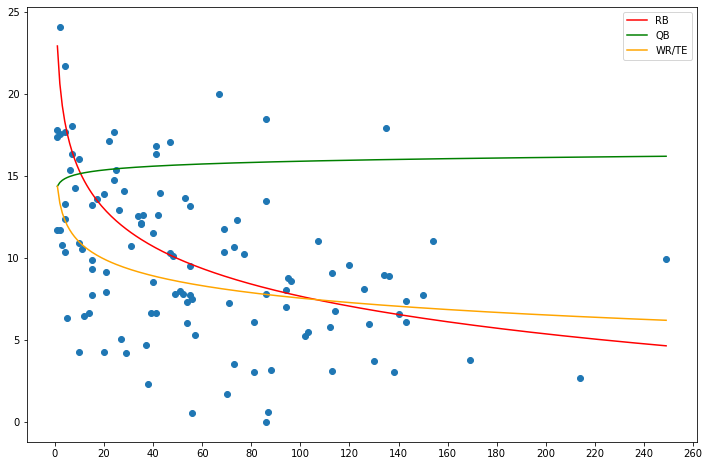

In [25]:
plt.figure(figsize=(12, 8))

x=np.arange(1, 250)
y1 = (orlm_4_results.params[0]) + (orlm_4_results.params[1] * np.log(x)) + \
     (orlm_4_results.params[2] * 1) + (orlm_4_results.params[3] * np.log(x))
y2 = (orlm_4_results.params[0]) + (orlm_4_results.params[1] * np.log(x)) + \
     (orlm_4_results.params[4] * np.log(x))
y3 = (orlm_4_results.params[0]) + (orlm_4_results.params[1] * np.log(x))

plt.scatter(x=rookies["draft_pick"], y=rookies["PPR"])
plt.plot(x,y1, color="red", label="RB")
plt.plot(x,y2, color="green", label="QB")
plt.plot(x,y3, color="orange", label="WR/TE")
plt.legend()
plt.xticks(np.arange(0, 280, 20));

We can see here that being drafted in the first or second round makes a huge difference for RBs, a fairly large difference for WRs, and a minimal difference for QBs. However, this is not to say that QBs drafted later are better, but rather to say that there aren't QBs drafted later that have an impact to be included in fantasy data. 

-----------

Everyone is excited about a rookie that steps into a good offense, but how much does that offense's success lend itself to predicting how highly we should draft that rookie?

To do this, we'll have to load in data on each team's success, so that we can eventually add it on to the information about the player.

In [26]:
team_data = pd.read_csv("season_data/team_data.csv")
team_data.head()

Team  PassYPG  RunYPG  TotalYPG   PPG  Year
0   Broncos    340.2   117.1     457.3  37.9  2013
1    Eagles    256.9   160.4     417.2  27.6  2013
2   Packers    266.8   133.5     400.2  26.1  2013
3    Saints    307.4    92.1     399.4  25.9  2013
4  Chargers    270.5   122.8     393.3  24.8  2013

In [27]:
rookie_train["prior_year"] = rookie_train["Year"] - 1
rookie_train = rookie_train.merge(team_data, how="inner", left_on=["Team", "prior_year"], right_on=["Team", "Year"])

In [28]:
rookie_train

Player      Team FantPos  Age   G  Cmp  PassAtt  PassYds  \
0         JamesWhite  Patriots      RB   22   3  0.0      0.0      0.0   
1         ToddGurley      Rams      RB   21  13  0.0      0.0      0.0   
2      NelsonAgholor    Eagles      WR   22  13  0.0      0.0      0.0   
3     DarwinThompson    Chiefs      RB   22  12  0.0      0.0      0.0   
4         KareemHunt    Chiefs      RB   22  16  0.0      0.0      0.0   
..               ...       ...     ...  ...  ..  ...      ...      ...   
86  DarrellHenderson      Rams      RB   22  13  0.0      0.0      0.0   
87      TerranceWest    Browns      RB   23  14  0.0      0.0      0.0   
88       CodyLatimer   Broncos      WR   22   8  0.0      0.0      0.0   
89    JonathanTaylor     Colts      RB   21  15  0.0      0.0      0.0   
90      CoreyColeman    Browns      WR   22  10  0.0      0.0      0.0   

    PassTD  Int  ...  Soph  Third  RB  QB  prior_year  PassYPG  RunYPG  \
0      0.0  0.0  ...     0      0   1   0        2013    255.4   129.1   
1      0.0  0.0  ...     0      0   1   0        2014    212.5   102.2   
2      0.0  0.0  ...     0      0   0   0        2014    272.2   124.5   
3      0.0  0.0  ...     0      0   1   0        2018    309.7   115.9   
4      0.0  0.0  ...     0      0   1   0        2016    233.8   109.2   
..     ...  ...  ...   ...    ...  ..  ..         ...      ...     ...   
86     0.0  0.0  ...     0      0   1   0        2018    281.7   139.4   
87     0.0  0.0  ...     0      0   1   0        2013    252.9    86.4   
88     0.0  0.0  ...     0      0   0   0        2013    340.2   117.1   
89     0.0  0.0  ...     0      0   1   0        2019    194.2   133.1   
90     0.0  0.0  ...     0      0   0   0        2015    236.4    95.6   

    TotalYPG   PPG  Year_y  
0      384.5  27.8    2013  
1      314.7  20.2    2014  
2      396.8  29.6    2014  
3      425.6  35.3    2018  
4      343.0  24.3    2016  
..       ...   ...     ...  
86     421.1  32.9    2018  
87     339.4  19.2    2013  
88     457.3  37.9    2013  
89     327.4  22.6    2019  
90     331.9  17.4    2015  

[91 rows x 36 columns]

Now that we've loaded in the previous season's team data, we will see if it can help us predict the player's performance better. First, we will add the team's points per game, as it would make sense that a team that scores more would produce more scoring opportunities for its rookies.

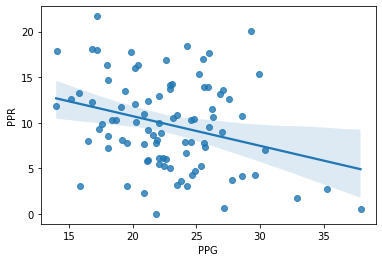

In [29]:
sns.regplot(x="PPG", y="PPR", data=rookie_train);

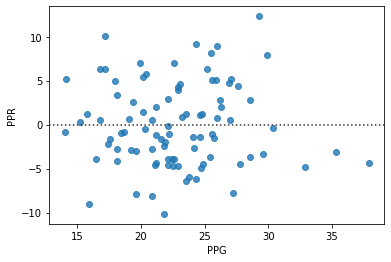

In [30]:
sns.residplot(x=rookie_train["PPG"], y=rookie_train["PPR"]);

The initial plot of points per game indicates a relatively linear trend, and the residual plot proves this. 

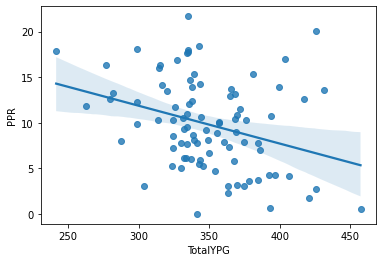

In [31]:
sns.regplot(x="TotalYPG", y="PPR", data=rookie_train);

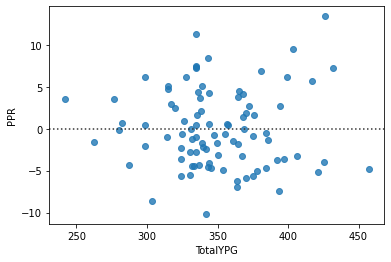

In [32]:
sns.residplot(x=rookie_train["TotalYPG"], y=rookie_train["PPR"]);

When we examine these points, we also see a linear trend with evenly distributed residuals. Therefore, we can implement these two features into the next model. However, the trends here indicate that as an offense gets better, the player scores less PPR points per game. This bucks the notion of a young player stepping into a good offense and rather indicates that bad teams have more opportunity for production.

In [33]:
orlm_5_X = pd.DataFrame({"pick": np.log(rookie_train["draft_pick"]), 
                         "RB": rookie_train["RB"],
                         "RB_interact": rookie_train["RB"]*(np.log(rookie_train["draft_pick"])), 
                         "QB_interact": rookie_train["QB"]*(np.log(rookie_train["draft_pick"])),
                         "PPG": rookie_train["PPG"], "TotalYds": rookie_train["TotalYPG"]})
orlm_5_X = sm.add_constant(orlm_5_X)

orlm_5 = sm.OLS(rookie_train["PPR"], orlm_5_X)
orlm_5_results = orlm_5.fit()
print(orlm_5_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     7.289
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           2.74e-06
Time:                        11:33:05   Log-Likelihood:                -254.87
No. Observations:                  91   AIC:                             523.7
Df Residuals:                      84   BIC:                             541.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          22.6567      4.733      4.787      

The p-value is hugely above .05 when we add both terms, so let's check colinearity. The VIF indicates that PPG is still lacks significance, but on the other hand, total yards per game is reasonable, so then we will remove points per game and move on.

In [34]:
for idx in np.arange(len(orlm_5_X.columns.tolist())):
    print(f"VIF of {orlm_5_X.columns.tolist()[idx]}: {variance_inflation_factor(orlm_5_X, idx)}")

VIF of const: 118.67941599854133
VIF of pick: 2.2728943749912647
VIF of RB: 14.148574073039603
VIF of RB_interact: 17.93582937528081
VIF of QB_interact: 1.079213198468458
VIF of PPG: 3.8323139608878956
VIF of TotalYds: 3.8436825743294185


In [35]:
orlm_6_X = pd.DataFrame({"pick": np.log(rookie_train["draft_pick"]), 
                         "RB": rookie_train["RB"],
                         "RB_interact": rookie_train["RB"]*(np.log(rookie_train["draft_pick"])), 
                         "QB_interact": rookie_train["QB"]*(np.log(rookie_train["draft_pick"])),
                         "TotalYds": rookie_train["TotalYPG"]})
orlm_6_X = sm.add_constant(orlm_6_X)

orlm_6 = sm.OLS(rookie_train["PPR"], orlm_6_X)
orlm_6_results = orlm_6.fit()
print(orlm_6_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     8.847
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           8.60e-07
Time:                        11:33:10   Log-Likelihood:                -254.88
No. Observations:                  91   AIC:                             521.8
Df Residuals:                      85   BIC:                             536.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          22.3974      4.167      5.375      

After this modification, there are no terms that stick out. Because of this, we are satisfied with our model.

-----------

Though our R^2 value is only at 40%, we are somewhat satisfied with the model. We will now apply this to the test data.

In [36]:
rookie_test

Player      Team FantPos  Age   G    Cmp  PassAtt  PassYds  \
413          TajaeSharpe    Titans      WR   22  16   0.00     0.00     0.00   
890      JustinJefferson   Vikings      WR   21  16   0.00     0.00     0.00   
612            NickChubb    Browns      RB   23  16   0.00     0.00     0.00   
557           CoreyDavis    Titans      WR   22  11   0.00     0.00     0.00   
119           MarqiseLee   Jaguars      WR   23  13   0.00     0.00     0.00   
579        SaquonBarkley    Giants      RB   21  16   0.00     0.00     0.00   
1094       MichaelCarter      Jets      RB   22  14   0.00     0.00     0.00   
821        MecoleHardman    Chiefs      WR   21  16   0.00     0.00     0.00   
780          DeeboSamuel     49ers      WR   23  15   0.00     0.00     0.00   
524         SamajePerine       WFT      RB   22  16   0.00     0.00     0.00   
1093       MichaelCarter      Jets      RB   22  14   0.00     0.00     0.00   
51         AndreWilliams    Giants      RB   22  16   0.00     0.00     0.00   
1105  RhamondreStevenson  Patriots      RB   23  12   0.00     0.00     0.00   
236        AmeerAbdullah     Lions      RB   22  16   0.00     0.00     0.00   
935            JoeBurrow   Bengals      QB   24  10  26.40    40.40   268.80   
210        MarcusMariota    Titans      QB   22  12  19.17    30.83   234.83   
1086          ZachWilson      Jets      QB   22  13  16.38    29.46   179.54   
989        HenryRuggsIII   Raiders      WR   21  13   0.00     0.00     0.00   
404            TylerBoyd   Bengals      WR   22  16   0.00     0.00     0.00   
1080            MacJones  Patriots      QB   23  17  20.71    30.65   223.59   
713        JordanWilkins     Colts      RB   24  16   0.00     0.00     0.00   
246        DevinFunchess  Panthers      WR   21  16   0.00     0.00     0.00   
235            MattJones       WFT      RB   22  13   0.00     0.00     0.00   

      PassTD   Int  ...  PosRank  OvRank  Year    adp  draft_pick  draft_year  \
413     0.00  0.00  ...       78     NaN  2016  115.1         140        2016   
890     0.00  0.00  ...        6    24.0  2020  121.5          22        2020   
612     0.00  0.00  ...       15    40.0  2018  126.4          35        2018   
557     0.00  0.00  ...      102     NaN  2017  110.9           5        2017   
119     0.00  0.00  ...       92     NaN  2014  143.6          39        2014   
579     0.00  0.00  ...        2     2.0  2018    6.5           2        2018   
1094    0.00  0.00  ...       30     NaN  2021   76.1         154        2021   
821     0.00  0.00  ...       49     NaN  2019  137.7          56        2019   
780     0.00  0.00  ...       26    70.0  2019  151.8          36        2019   
524     0.00  0.00  ...       42     NaN  2017  126.8         114        2017   
1093    0.00  0.00  ...       30     NaN  2021   76.1         107        2021   
51      0.00  0.00  ...       21    67.0  2014  113.4         113        2014   
1105    0.00  0.00  ...       36     NaN  2021  121.3         120        2021   
236     0.00  0.00  ...       41     NaN  2015   41.5          54        2015   
935     1.30  0.50  ...       25     NaN  2020  135.7           1        2020   
210     1.58  0.83  ...       22     NaN  2015  162.6           2        2015   
1086    0.69  0.85  ...       30     NaN  2021  149.1           2        2021   
989     0.00  0.00  ...       87     NaN  2020  104.5          12        2020   
404     0.00  0.00  ...       70     NaN  2016  137.6          55        2016   
1080    1.29  0.76  ...       18     NaN  2021  157.4          15        2021   
713     0.00  0.00  ...       76     NaN  2018  143.1         169        2018   
246     0.00  0.00  ...       59     NaN  2015   96.1          41        2015   
235     0.00  0.00  ...       40     NaN  2015  124.4          95        2015   

      Experience  Rookie  Soph  Third  
413            0       1     0      0  
890            0       1     0      0  
612            0       1     0  

In [37]:
rookie_test["RB"] = ((rookie_test.FantPos=="RB")*1).copy()
rookie_test["QB"] = ((rookie_test.FantPos=="QB")*1).copy()

In [38]:
rookie_test["prior_year"] = rookie_test["Year"] - 1
rookie_test = rookie_test.merge(team_data, how="inner", left_on=["Team", "prior_year"], right_on=["Team", "Year"])

In [39]:
rookie_test

Player      Team FantPos  Age   G    Cmp  PassAtt  PassYds  \
0          TajaeSharpe    Titans      WR   22  16   0.00     0.00     0.00   
1      JustinJefferson   Vikings      WR   21  16   0.00     0.00     0.00   
2            NickChubb    Browns      RB   23  16   0.00     0.00     0.00   
3           CoreyDavis    Titans      WR   22  11   0.00     0.00     0.00   
4           MarqiseLee   Jaguars      WR   23  13   0.00     0.00     0.00   
5        SaquonBarkley    Giants      RB   21  16   0.00     0.00     0.00   
6        MichaelCarter      Jets      RB   22  14   0.00     0.00     0.00   
7        MichaelCarter      Jets      RB   22  14   0.00     0.00     0.00   
8           ZachWilson      Jets      QB   22  13  16.38    29.46   179.54   
9        MecoleHardman    Chiefs      WR   21  16   0.00     0.00     0.00   
10         DeeboSamuel     49ers      WR   23  15   0.00     0.00     0.00   
11        SamajePerine       WFT      RB   22  16   0.00     0.00     0.00   
12       AndreWilliams    Giants      RB   22  16   0.00     0.00     0.00   
13  RhamondreStevenson  Patriots      RB   23  12   0.00     0.00     0.00   
14            MacJones  Patriots      QB   23  17  20.71    30.65   223.59   
15       AmeerAbdullah     Lions      RB   22  16   0.00     0.00     0.00   
16           JoeBurrow   Bengals      QB   24  10  26.40    40.40   268.80   
17       MarcusMariota    Titans      QB   22  12  19.17    30.83   234.83   
18       HenryRuggsIII   Raiders      WR   21  13   0.00     0.00     0.00   
19           TylerBoyd   Bengals      WR   22  16   0.00     0.00     0.00   
20       JordanWilkins     Colts      RB   24  16   0.00     0.00     0.00   
21       DevinFunchess  Panthers      WR   21  16   0.00     0.00     0.00   
22           MattJones       WFT      RB   22  13   0.00     0.00     0.00   

    PassTD   Int  ...  Soph  Third  RB  QB  prior_year  PassYPG  RunYPG  \
0     0.00  0.00  ...     0      0   0   0        2015    218.9    92.8   
1     0.00  0.00  ...     0      0   0   0        2019    220.2   133.3   
2     0.00  0.00  ...     0      0   1   0        2017    201.8   107.1   
3     0.00  0.00  ...     0      0   0   0        2016    221.3   136.7   
4     0.00  0.00  ...     0      0   0   0        2013    215.1    78.8   
5     0.00  0.00  ...     0      0   1   0        2017    217.4    96.8   
6     0.00  0.00  ...     0      0   1   0        2020    174.8   105.2   
7     0.00  0.00  ...     0      0   1   0        2020    174.8   105.2   
8     0.69  0.85  ...     0      0   0   1        2020    174.8   105.2   
9     0.00  0.00  ...     0      0   0   0        2018    309.7   115.9   
10    0.00  0.00  ...     0      0   0   0        2018    241.7   118.9   
11    0.00  0.00  ...     0      0   1   0        2016    297.4   106.0   
12    0.00  0.00  ...     0      0   1   0        2013    224.2    83.2   
13    0.00  0.00  ...     0      0   1   0        2020    180.6   146.6   
14    1.29  0.76  ...     0      0   0   1        2020    180.6   146.6   
15    0.00  0.00  ...     0      0   1   0        2014    251.9    88.9   
16    1.30  0.50  ...     0      0   0   1        2019    228.2    94.8   
17    1.58  0.83  ...     0      0   0   1        2014    213.2    90.4   
18    0.00  0.00  ...     0      0   0   0        2019    245.4   118.3   
19    0.00  0.00  ...     0      0   0   0        2015    245.2   112.8   
20    0.00  0.00  ...     0      0   1   0        2017    180.8   103.8   
21    0.00  0.00  ...     0      0   0   0        2014    219.4   127.2   
22    0.00  0.00  ...     0      0   1   0        2014    252.9   105.7   

    TotalYPG   PPG  Year_y  
0      311.8  18.7    2015  
1      353.5  25.4    2019  
2      308.9  14.6    2017  
3      358.0  23.8    2016  
4      293.8  15.4    2013  
5      314.2  15.4    2017  
6      279.9  15.2    2020  
7      279.9  15.2    2020  
8      279.9  15.2    2020  
9      425.6  35.3    2018  
10     360.6  21.4    2

In [40]:
orlm_test_X = pd.DataFrame({"pick": np.log(rookie_test["draft_pick"]), 
                            "RB": rookie_test["RB"],
                            "RB_interact": rookie_test["RB"]*(np.log(rookie_test["draft_pick"])), 
                            "QB_interact": rookie_test["QB"]*(np.log(rookie_test["draft_pick"])),
                            "TotalYds": rookie_test["TotalYPG"]})
orlm_test_X = sm.add_constant(orlm_test_X)

test_preds = orlm_6_results.predict(orlm_test_X)
test_preds.head()

0     8.482184
1     9.678802
2    12.110116
3    11.368588
4    10.494191
dtype: float64

In [44]:
test_r_sq = (np.corrcoef(rookie_test["PPR"], test_preds))[0, 1]**2
test_r_sq

0.5723766494631763

With the test values, the r^2 is actually higher, which indicates that our model is robust and good.

Let's now apply it to this year's rookies to predict the best performers.

In [45]:
import requests
from bs4 import BeautifulSoup

headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = "https://www.pro-football-reference.com/years/2022/draft.htm"
page_tree = requests.get(page, headers=headers)
page_soup = BeautifulSoup(page_tree.content, 'html.parser')

players = page_soup.find_all("td", {"class": "left", "data-stat": "player"})
picks = page_soup.find_all("td", {"class": "right", "data-stat": "draft_pick"})
positions = page_soup.find_all("td", {"class": "left", "data-stat": "pos"})
teams = page_soup.find_all("td", {"class": "left", "data-stat": "team"})

In [46]:
players_list = []
picks_list = []
position_list = []
team_list = []

for i in range(0, len(picks)):
    players_list.append(players[i].text)
    picks_list.append(picks[i].text)
    position_list.append(positions[i].text)
    team_list.append(teams[i].text)
    
draft_2022 = pd.DataFrame({"player": players_list, "draft_pick": picks_list, 
                           "position": position_list, "team": team_list,
                           "draft_year": 2022})

draft_2022.head()

player draft_pick position team  draft_year
0      Travon Walker          1       DE  JAX        2022
1   Aidan Hutchinson          2       DE  DET        2022
2     Derek Stingley          3       CB  HOU        2022
3      Ahmad Gardner          4       CB  NYJ        2022
4  Kayvon Thibodeaux          5       DE  NYG        2022

In [47]:
fantasy_rookies_2022 = draft_2022[draft_2022.position.isin(["RB", "WR", "QB", "TE"])]
squads = fantasy_rookies_2022["team"].replace({'DAL': "Cowboys", 'PIT': "Steelers", 'SEA': "Seahawks", 
                                  'CHI': "Bears", 'HOU': "Texans", 'GNB': "Packers", 
                                  'DEN': "Broncos", 'NWE': "Patriots", 'KAN': "Chiefs",
                                  'IND': "Colts", 'NYG': "Giants", 'BAL': "Ravens", 
                                  'ATL': "Falcons", 'PHI': "Eagles", 'MIA': "Dolphins", 
                                  'SDG': "Chargers", 'CIN': "Bengals", 'TAM': "Buccaneers",
                                  'NOR': "Saints", 'WAS': "WFT", 'CAR': "Panthers", 'DET': "Lions", 
                                  'MIN': "Vikings", 'SFO': "49ers", 'TEN': "Titans", 'NYJ': "Jets", 
                                  'BUF':"Bills", 'ARI': "Cardinals", 'OAK': "Raiders", 'JAX': "Jaguars", 
                                  'CLE': "Browns", 'STL': "Rams", 'LAR': "Rams", 'LAC': "Chargers", 
                                  'LVR': "Raiders"})
fantasy_rookies_2022["team"] = squads
fantasy_rookies_2022

player draft_pick position      team  draft_year
7        Drake London          8       WR   Falcons        2022
9      Garrett Wilson         10       WR      Jets        2022
10        Chris Olave         11       WR    Saints        2022
11   Jameson Williams         12       WR     Lions        2022
15       Jahan Dotson         16       WR       WFT        2022
..                ...        ...      ...       ...         ...
249    Brittain Brown        250       RB   Raiders        2022
250     Isaih Pacheco        251       RB    Chiefs        2022
257      Samori Toure        258       WR   Packers        2022
259    Zander Horvath        260       RB  Chargers        2022
261       Brock Purdy        262       QB     49ers        2022

[79 rows x 5 columns]

In [48]:
fantasy_rookies_2022["RB"] = ((fantasy_rookies_2022.position=="RB")*1).copy()
fantasy_rookies_2022["QB"] = ((fantasy_rookies_2022.position=="QB")*1).copy()

In [49]:
fantasy_rookies_2022["prior_year"] = fantasy_rookies_2022["draft_year"] - 1
fantasy_rookies_2022 = fantasy_rookies_2022.merge(team_data, how="inner", left_on=["team", "prior_year"], right_on=["Team", "Year"])

In [56]:
fantasy_rookies_2022["draft_pick"] = fantasy_rookies_2022["draft_pick"].astype(int)

In [57]:
orlm_2022_X = pd.DataFrame({"pick": np.log(fantasy_rookies_2022["draft_pick"]), 
                            "RB": fantasy_rookies_2022["RB"],
                            "RB_interact": fantasy_rookies_2022["RB"]*(np.log(fantasy_rookies_2022["draft_pick"])), 
                            "QB_interact": fantasy_rookies_2022["QB"]*(np.log(fantasy_rookies_2022["draft_pick"])),
                            "TotalYds": fantasy_rookies_2022["TotalYPG"]})
orlm_2022_X = sm.add_constant(orlm_2022_X)

preds_2022 = orlm_6_results.predict(orlm_2022_X)
fantasy_rookies_2022["PPR_preds"] = preds_2022

In [68]:
best_picks = fantasy_rookies_2022[fantasy_rookies_2022["position"].isin(["RB", "WR"])].sort_values("PPR_preds", ascending=False).head(20)

In [71]:
best_picks = best_picks[["player", "draft_pick", "position", "team", "PPR_preds"]]

In [72]:
best_picks

player  draft_pick position      team  PPR_preds
0        Drake London           8       WR   Falcons  12.169452
5         Breece Hall          36       RB      Jets  12.086025
4      Garrett Wilson          10       WR      Jets  11.831918
7         Chris Olave          11       WR    Saints  11.764016
27     Kenneth Walker          41       RB  Seahawks  11.239087
8    Jameson Williams          12       WR     Lions  11.199548
10       Jahan Dotson          16       WR       WFT  10.823975
32       John Metchie          44       WR    Texans  10.745067
30  Wan'Dale Robinson          43       WR    Giants  10.539988
14      Treylon Burks          18       WR    Titans  10.201777
20     George Pickens          52       WR  Steelers   9.596749
33      Dameon Pierce         107       RB    Texans   9.422426
48        Velus Jones          71       WR     Bears   9.420257
24   Christian Watson          34       WR   Packers   8.842287
39        Alec Pierce          53       WR     Colts   8.770489
68      Erik Ezukanma         125       WR  Dolphins   8.741757
35    Tyquan Thornton          50       WR  Patriots   8.681828
11     Brian Robinson          98       RB       WFT   8.542422
46         James Cook          63       RB     Bills   8.436654
21      Calvin Austin         138       WR  Steelers   8.408501

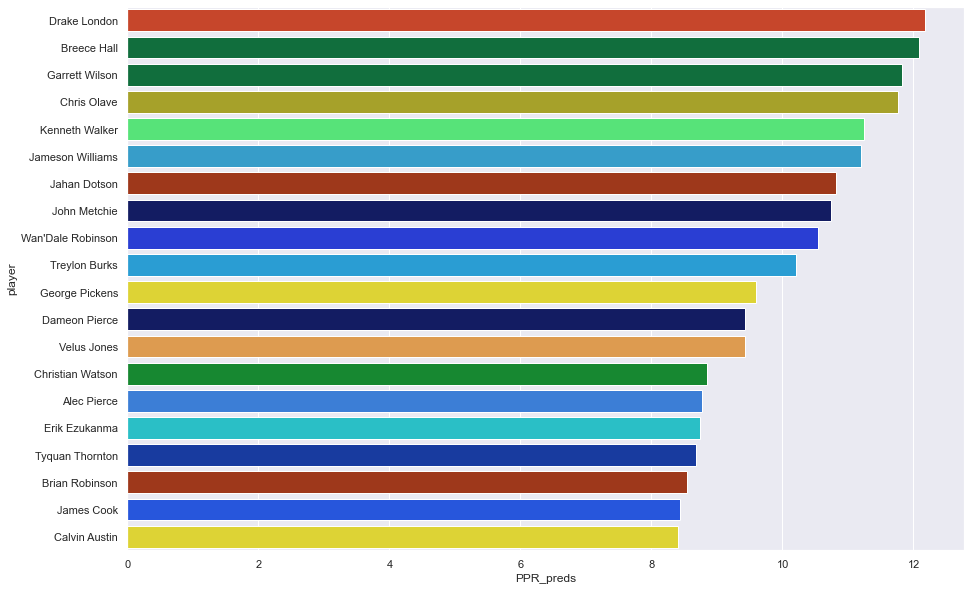

In [84]:
sns.set(rc={'figure.figsize':(15,10)})
team_palette = ["#E03511", "#027D3C", "#027D3C", "#BBB415", "#40FA6D", "#1EA7E2", "#B42C05",
                "#06126F", "#0E29EF", "#0EA7EF", "#F9EC19", "#06126F", "#F49C38", "#049B27", 
                "#227AF0", "#10D7E0", "#0230B5", "#B42C05", "#0947FA", "#F9EC19"]
sns.barplot(x="PPR_preds", y="player", data=best_picks, palette=team_palette).figure.savefig("rookie_barplot.png");